# Data Analysis

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np

# Load CSV
df = pd.read_csv("data_main.csv", parse_dates=["date"])
df = df[df["date"] <= "2024-12-31"]


# Basic overview
print(df.describe())


                                date    vix_close  total_dollar_volume  \
count                           5285  5285.000000         5.285000e+03   
mean   2014-07-01 17:59:31.390728448    18.978698         2.388125e+11   
min              2004-01-02 00:00:00     9.140000         3.347195e+10   
25%              2009-04-02 00:00:00    13.390000         1.550802e+11   
50%              2014-07-02 00:00:00    16.460000         1.966074e+11   
75%              2019-10-01 00:00:00    21.840000         2.985651e+11   
max              2024-12-31 00:00:00    82.690000         1.188085e+12   
std                              NaN     8.616388         1.254396e+11   

        vix_close_z  log_total_dollar_volume  
count  5.285000e+03              5285.000000  
mean  -8.604491e-17                26.077133  
min   -1.141859e+00                24.233974  
25%   -6.486127e-01                25.767208  
50%   -2.923149e-01                26.004474  
75%    3.320767e-01                26.422254  
max 

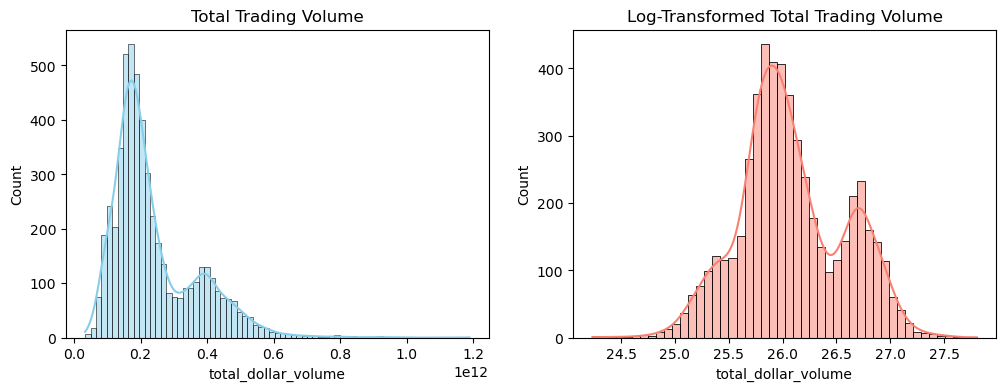

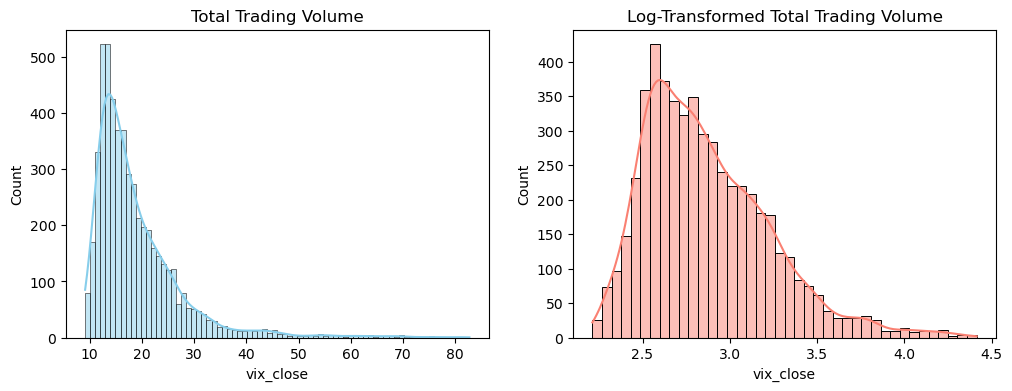

In [30]:
variables = ['total_dollar_volume', 'vix_close']

for var in variables:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Raw data
    sns.histplot(df[var], kde=True, ax=axes[0], color='skyblue')
    axes[0].set_title(f"Total Trading Volume")
    
    # Log-transformed datavix_close
    sns.histplot(np.log(df[var]), kde=True, ax=axes[1], color='salmon')
    axes[1].set_title(f"Log-Transformed Total Trading Volume")
    
    plt.show()



---- TOTAL_DOLLAR_VOLUME ----
Normality test (raw):    p = 0.00000
Normality test (log):    p = 0.00000


/Users/fredrikfuglerudflugstad/miniconda3/envs/finance/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5285.
  res = hypotest_fun_out(*samples, **kwds)


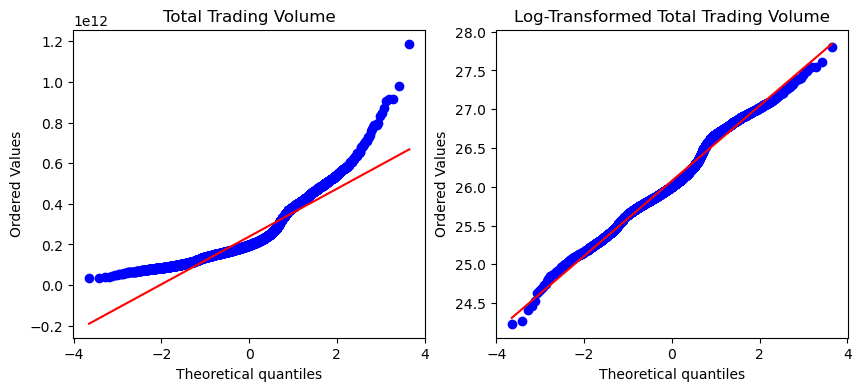


---- VIX_CLOSE ----
Normality test (raw):      p = 0.00000
Normality test (z-score):  p = 0.00000


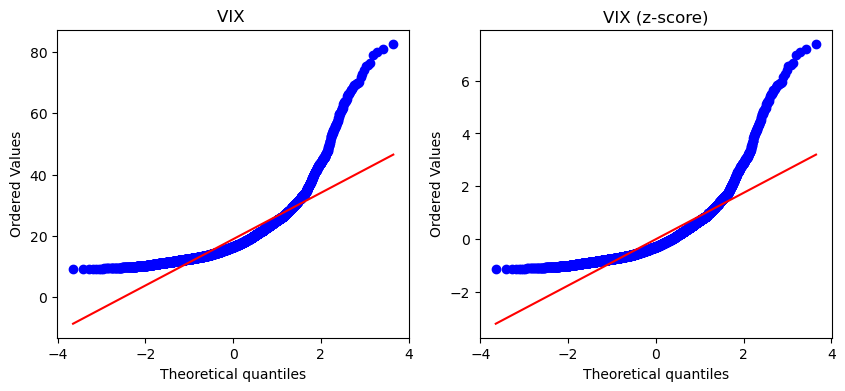

In [31]:
for var in variables:
    print(f"\n---- {var.upper()} ----")

    # Handle VIX: use raw + z-score
    if var.lower() == "vix_close":
        stat_raw, p_raw = stats.shapiro(df[var])
        stat_z,   p_z   = stats.shapiro(df["vix_close_z"])

        print(f"Normality test (raw):      p = {p_raw:.5f}")
        print(f"Normality test (z-score):  p = {p_z:.5f}")

        # Q–Q plots
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        stats.probplot(df[var], dist="norm", plot=axes[0])
        axes[0].set_title("VIX ")
        stats.probplot(df["vix_close_z"], dist="norm", plot=axes[1])
        axes[1].set_title("VIX (z-score)")
        plt.show()

    # Handle volume: raw + log
    else:
        stat_raw, p_raw = stats.shapiro(df[var])
        stat_log, p_log = stats.shapiro(np.log(df[var]))

        print(f"Normality test (raw):    p = {p_raw:.5f}")
        print(f"Normality test (log):    p = {p_log:.5f}")

        # Q–Q plots
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        stats.probplot(df[var], dist="norm", plot=axes[0])
        axes[0].set_title(f"Total Trading Volume")
        stats.probplot(np.log(df[var]), dist="norm", plot=axes[1])
        axes[1].set_title(f"Log-Transformed Total Trading Volume")
        plt.show()


In [16]:
# Split at March 2020
split_date = "2020-03-01"
df_pre = df[df["date"] < split_date]
df_post = df[df["date"] >= split_date]

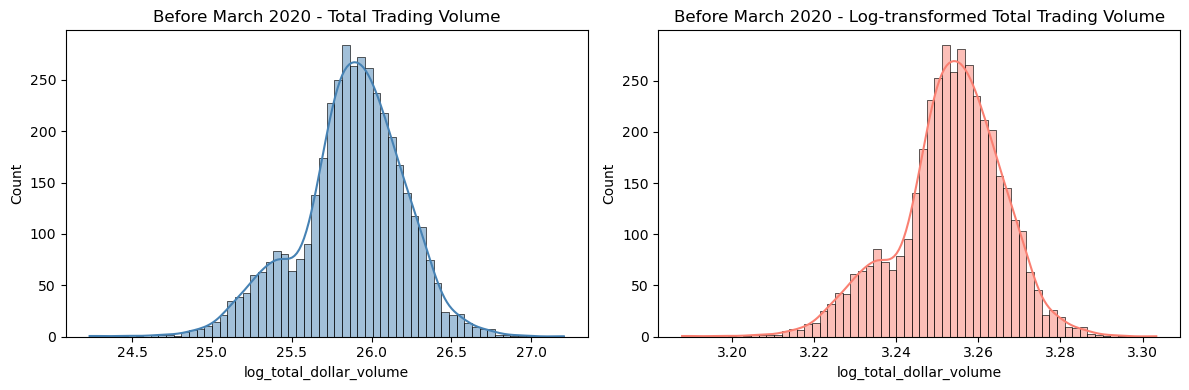

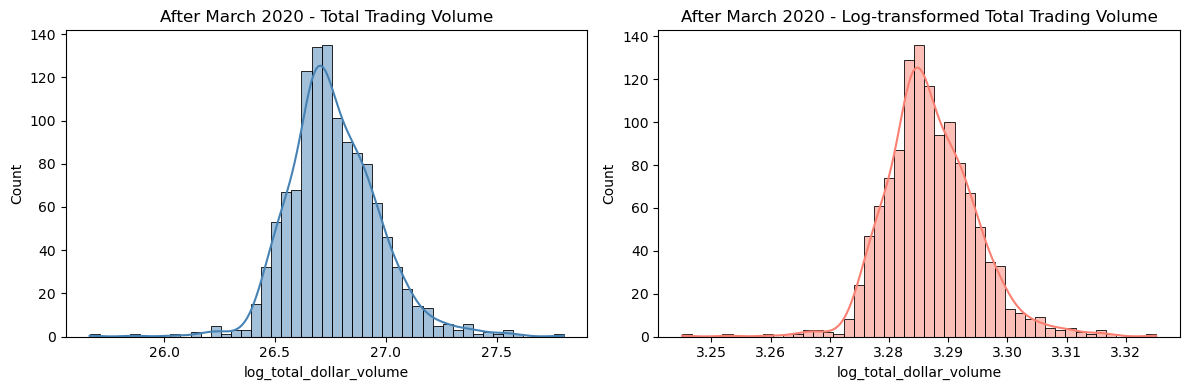

In [28]:
def compare_distributions(data, var, title):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    sns.histplot(data[var], kde=True, ax=axes[0], color="steelblue")
    axes[0].set_title(f"{title} - Total Trading Volume")
    
    sns.histplot(np.log(data[var]), kde=True, ax=axes[1], color="salmon")
    axes[1].set_title(f"{title} - Log-transformed Total Trading Volume")
    
    plt.tight_layout()
    plt.show()

compare_distributions(df_pre, "log_total_dollar_volume", "Before March 2020")
compare_distributions(df_post, "log_total_dollar_volume", "After March 2020")


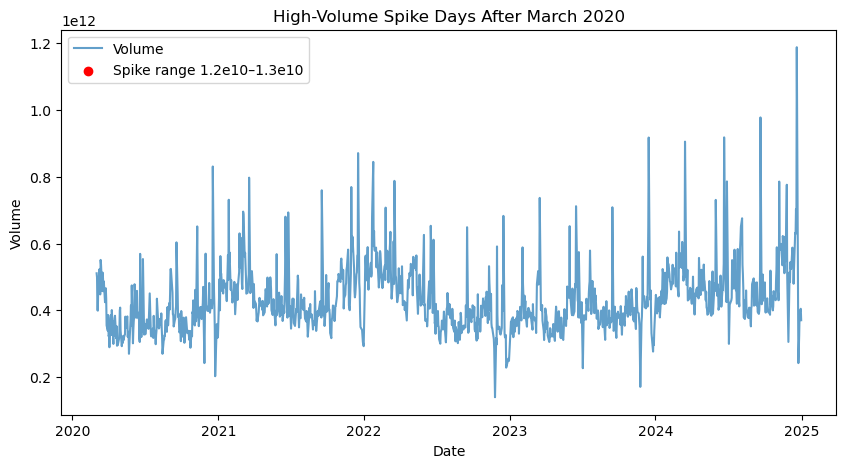

In [19]:
# Define your interval of interest (you can adjust these bounds slightly)
lower, upper = 1.20e10, 1.30e10

# Filter the dataset for volumes within that spike range
spike_dates = df_post[(df_post["total_dollar_volume"] >= lower) & (df_post["total_dollar_volume"] <= upper)]

# Sort by volume to see if values are identical or clustered
spike_dates = spike_dates.sort_values("total_dollar_volume", ascending=False)

spike_dates[["date", "total_dollar_volume"]]



plt.figure(figsize=(10,5))
plt.plot(df_post["date"], df_post["total_dollar_volume"], label="Volume", alpha=0.7)
plt.scatter(spike_dates["date"], spike_dates["total_dollar_volume"], color="red", label="Spike range 1.2e10–1.3e10")
plt.legend()
plt.title("High-Volume Spike Days After March 2020")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.show()


In [32]:
# Define your spike range
lower, upper = 1.20e10, 1.30e10

# Filter for dates after March 2020 within that range
spike_dates = df_post[(df_post["total_dollar_volume"] >= lower) & (df_post["total_dollar_volume"] <= upper)]

# Print all matching dates and volumes
print(spike_dates[["date", "total_dollar_volume"]].sort_values("date"))


Empty DataFrame
Columns: [date, total_dollar_volume]
Index: []


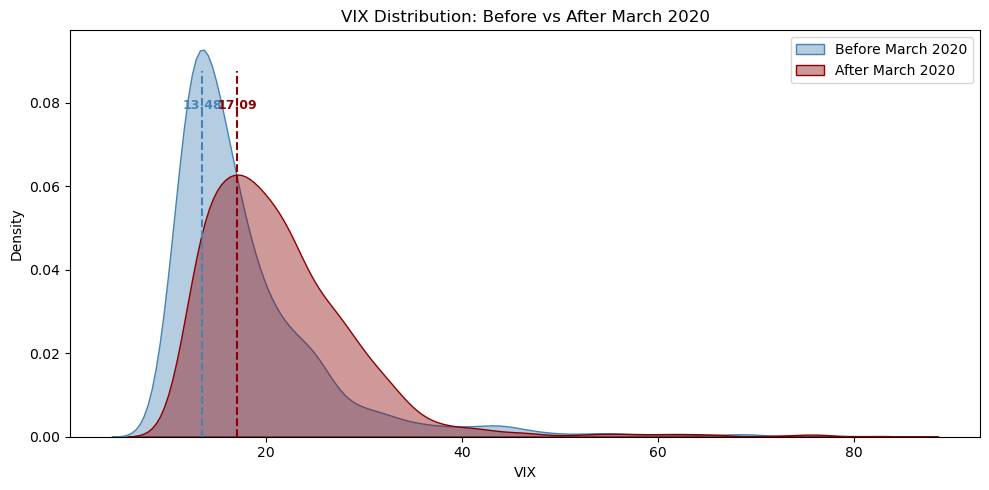

Peak (Before March 2020): 13.48
Peak (After March 2020):  17.09


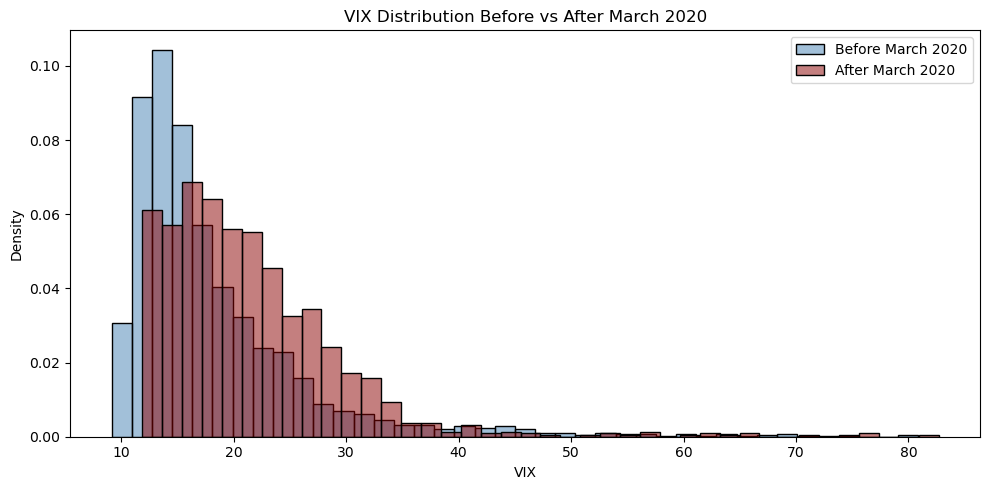

In [33]:
from scipy.stats import gaussian_kde


# Compute KDEs manually
x_pre = df_pre["vix_close"].dropna()
x_post = df_post["vix_close"].dropna()

kde_pre = gaussian_kde(x_pre)
kde_post = gaussian_kde(x_post)

# Common grid for comparison
x_grid = np.linspace(min(df["vix_close"]), max(df["vix_close"]), 1000)

# Find the x position of the peak (mode)
peak_pre = x_grid[np.argmax(kde_pre(x_grid))]
peak_post = x_grid[np.argmax(kde_post(x_grid))]

# Plot KDEs
plt.figure(figsize=(10,5))
sns.kdeplot(x_pre, label="Before March 2020", color="steelblue", fill=True, alpha=0.4)
sns.kdeplot(x_post, label="After March 2020", color="darkred", fill=True, alpha=0.4)

# Add vertical lines and text for peaks
plt.axvline(peak_pre, color="steelblue", linestyle="--", ymax=0.9)
plt.axvline(peak_post, color="darkred", linestyle="--", ymax=0.9)

plt.text(peak_pre, plt.ylim()[1]*0.8, f"{peak_pre:.2f}", color="steelblue",
         ha="center", va="bottom", fontsize=9, fontweight="bold")
plt.text(peak_post, plt.ylim()[1]*0.8, f"{peak_post:.2f}", color="darkred",
         ha="center", va="bottom", fontsize=9, fontweight="bold")

plt.title("VIX Distribution: Before vs After March 2020")
plt.xlabel("VIX")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

print(f"Peak (Before March 2020): {peak_pre:.2f}")
print(f"Peak (After March 2020):  {peak_post:.2f}")



plt.figure(figsize=(10,5))

bins = 40  # you can adjust the bin count for smoothness

sns.histplot(df_pre["vix_close"], bins=bins, color="steelblue", alpha=0.5,
             label="Before March 2020", stat="density")
sns.histplot(df_post["vix_close"], bins=bins, color="darkred", alpha=0.5,
             label="After March 2020", stat="density")

plt.title("VIX Distribution Before vs After March 2020")
plt.xlabel("VIX")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

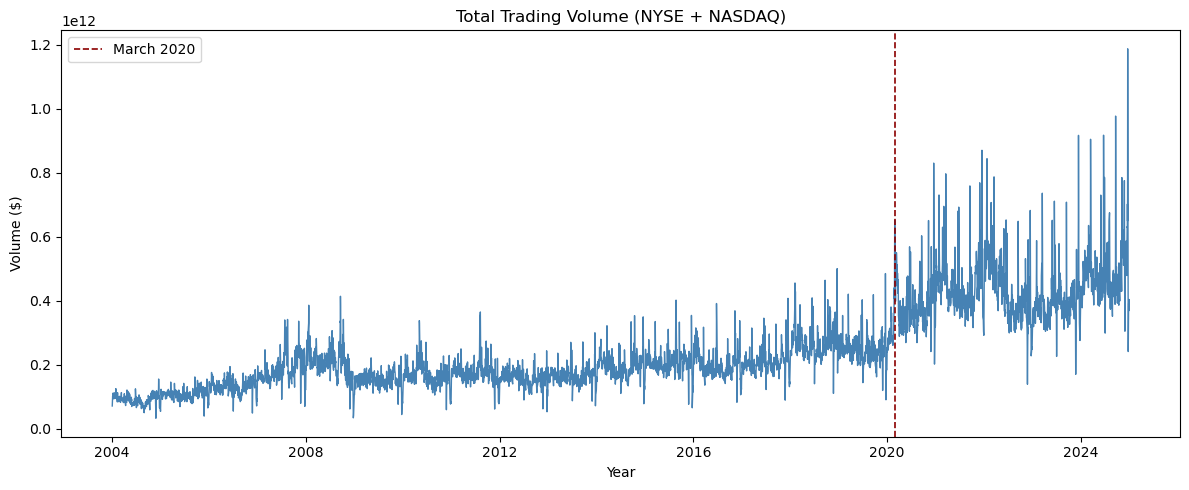

Before March 2020: 4067 days > 1.0×10¹⁰
After March 2020:  1218 days > 1.0×10¹⁰


In [34]:
plt.figure(figsize=(12,5))

sns.lineplot(data=df, x="date", y="total_dollar_volume", color="steelblue", linewidth=1)

# Highlight March 2020 as a reference line
plt.axvline(pd.to_datetime("2020-03-01"), color="darkred", linestyle="--", linewidth=1.2, label="March 2020")

plt.title("Total Trading Volume (NYSE + NASDAQ)")
plt.xlabel("Year")
plt.ylabel("Volume ($)")
plt.legend()
plt.tight_layout()
plt.show()


split_date = "2020-03-01"
pre_high = df[(df["date"] < split_date) & (df["total_dollar_volume"] > 1.0e10)]
post_high = df[(df["date"] >= split_date) & (df["total_dollar_volume"] > 1.0e10)]

print(f"Before March 2020: {len(pre_high)} days > 1.0×10¹⁰")
print(f"After March 2020:  {len(post_high)} days > 1.0×10¹⁰")

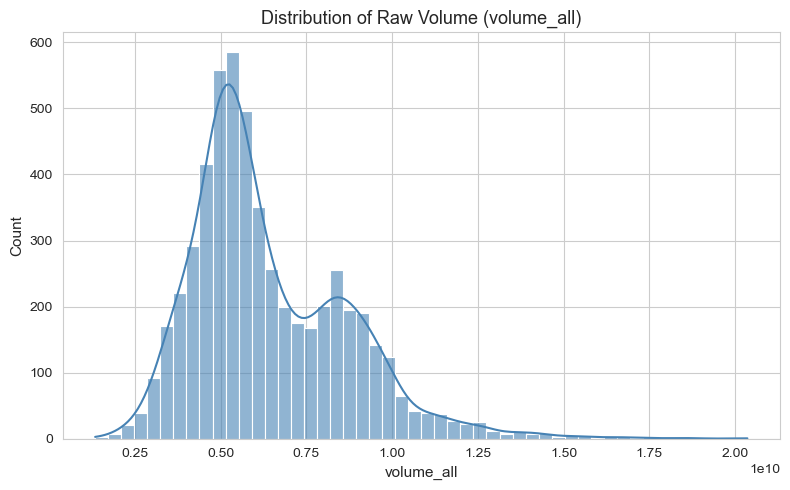

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Eksempel: les inn data – bytt gjerne til din egen fil
# df = pd.read_csv("data.csv")

# Hvis du allerede har df i minnet:
# df['volume_all'] = ...   # sørg for at kolonnen finnes

# Sett stil
sns.set_style("whitegrid")

# Plott histogram
plt.figure(figsize=(8, 5))
sns.histplot(df["volume_all"], bins=50, kde=True, color="steelblue", alpha=0.6)

plt.title("Distribution of Raw Volume (volume_all)", fontsize=13)
plt.xlabel("volume_all", fontsize=11)
plt.ylabel("Count", fontsize=11)

plt.tight_layout()
plt.show()


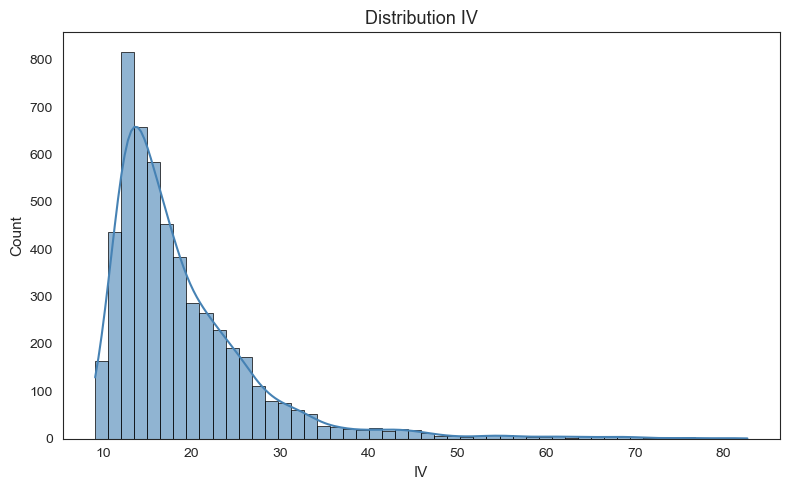

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Hvis df allerede finnes, hopp over innlasting
# df = pd.read_csv("data.csv")

# Fjern grid – bruk ren hvit bakgrunn
sns.set_style("white")

plt.figure(figsize=(8, 5))

# Samme farger som i eksempelet ditt
sns.histplot(
    df["vix_close"],
    bins=50,
    kde=True,
    color="steelblue",
    alpha=0.6,
    edgecolor="black",
    linewidth=0.5
)

# Gjør KDE-linjen tydelig
ax = plt.gca()
for line in ax.lines:
    line.set_color("steelblue")
    line.set_linewidth(1.5)

plt.title("Distribution IV", fontsize=13)
plt.xlabel("IV", fontsize=11)
plt.ylabel("Count", fontsize=11)

plt.tight_layout()
plt.show()


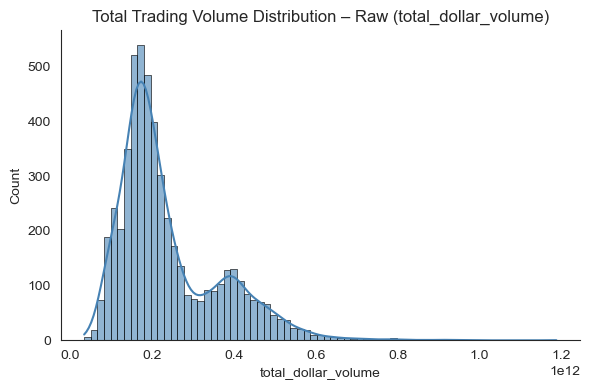

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_volume_distribution(data, var, title):
    # Opprett figur
    fig, ax = plt.subplots(figsize=(6, 4))
    
    # Plot histogram (samme stil som compare_distributions)
    sns.histplot(
        data[var],
        kde=True,
        ax=ax,
        color="steelblue",
        edgecolor="black",
        alpha=0.6
    )
    
    # Fjern grid for ren bakgrunn
    sns.despine()
    
    # Titler og akser
    ax.set_title(f"{title} – Raw ({var})")
    ax.set_xlabel(var)
    ax.set_ylabel("Count")
    
    plt.tight_layout()
    plt.show()

plot_volume_distribution(df, "total_dollar_volume", "Total Trading Volume Distribution")
